<a href="https://colab.research.google.com/github/ayoub-sys/machineLearning/blob/main/scanFile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-whois

#Feature extraction

In [ ]:
import ipaddress
import re
import urllib.request
from bs4 import BeautifulSoup
import socket
import requests
from googlesearch import search
import whois
from datetime import date, datetime
import time
from dateutil.parser import parse as date_parse


def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def generate_data_set(url):

    data_set = []

    if not re.match(r"^https?", url):
        url = "http://" + url

    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    except:
        response = ""
        soup = -999

    domain = re.findall(r"://([^/]+)/?", url)[0]
    if re.match(r"^www.", domain):
        domain = domain.replace("www.", "")
    whois_response = whois.whois(domain)

    rank_checker_response = requests.post("https://www.checkpagerank.net/index.php", {
        "name": domain
    })

    try:
        global_rank = int(re.findall(
            r"Global Rank: ([0-9]+)", rank_checker_response.text)[0])
    except:
        global_rank = -1

     
    # 1.UsingIP
    try:
        ipaddress.ip_address(url)
        data_set.append(-1)
    except:
        data_set.append(1)

     
    # 2.LongURL
    if len(url) < 54:
        data_set.append(1)
    elif len(url) >= 54 and len(url) <= 75:
        data_set.append(0)
    else:
        data_set.append(-1)

     
    # 3.ShortURL
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|tr\.im|link\.zip\.net', url)
    if match:
        data_set.append(-1)
    else:
        data_set.append(1)

    # 4.Symbol@
    if re.findall("@", url):
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 5.Redirecting//
    list = [x.start(0) for x in re.finditer('//', url)]
    if list[len(list)-1] > 6:
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 6.PrefixSuffix-
    if re.findall(r"https?://[^\-]+-[^\-]+/", url):
        data_set.append(-1)
    else:
        data_set.append(1)

     
    # 7.SubDomains
    if len(re.findall("\.", url)) == 1:
        data_set.append(1)
    elif len(re.findall("\.", url)) == 2:
        data_set.append(0)
    else:
        data_set.append(-1)

     
    # 8.HTTPS
    try:
        if response.text:
            data_set.append(1)
    except:
        data_set.append(-1)

     
    # 9.DomainRegLen
    expiration_date = whois_response.expiration_date
    registration_length = 0
    try:
        expiration_date = min(expiration_date)
        today = time.strftime('%Y-%m-%d')
        today = datetime.strptime(today, '%Y-%m-%d')
        registration_length = abs((expiration_date - today).days)

        if registration_length / 365 <= 1:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(-1)

     
    # 10.Favicon
    if soup == -999:
        data_set.append(-1)
    else:
        try:
            for head in soup.find_all('head'):
                for head.link in soup.find_all('link', href=True):
                    dots = [x.start(0)
                            for x in re.finditer('\.', head.link['href'])]
                    if url in head.link['href'] or len(dots) == 1 or domain in head.link['href']:
                        data_set.append(1)
                        raise StopIteration
                    else:
                        data_set.append(-1)
                        raise StopIteration
        except StopIteration:
            pass

     
    # 11. NonStdPort
    try:
        port = domain.split(":")[1]
        if port:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)

     
    # 12. HTTPSDomainURL
    if re.findall(r"^https://", url):
        data_set.append(1)
    else:
        data_set.append(-1)

     
    # 13. RequestURL
    i = 0
    success = 0
    if soup == -999:
        data_set.append(-1)
    else:
        for img in soup.find_all('img', src=True):
            dots = [x.start(0) for x in re.finditer('\.', img['src'])]
            if url in img['src'] or domain in img['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for audio in soup.find_all('audio', src=True):
            dots = [x.start(0) for x in re.finditer('\.', audio['src'])]
            if url in audio['src'] or domain in audio['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for embed in soup.find_all('embed', src=True):
            dots = [x.start(0) for x in re.finditer('\.', embed['src'])]
            if url in embed['src'] or domain in embed['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for iframe in soup.find_all('iframe', src=True):
            dots = [x.start(0) for x in re.finditer('\.', iframe['src'])]
            if url in iframe['src'] or domain in iframe['src'] or len(dots) == 1:
                success = success + 1
            i = i+1

        try:
            percentage = success/float(i) * 100
            if percentage < 22.0:
                data_set.append(1)
            elif((percentage >= 22.0) and (percentage < 61.0)):
                data_set.append(0)
            else:
                data_set.append(-1)
        except:
            data_set.append(1)

     
    # 14. AnchorURL
    percentage = 0
    i = 0
    unsafe = 0
    ex = True
    if soup == -999:
        data_set.append(-1)
    else:
        for a in soup.find_all('a', href=True):
            # 2nd condition was 'JavaScript ::void(0)' but we put JavaScript because the space between javascript and :: might not be there in the actual a['href']
            if "#" in a['href'] or "javascript" in a['href'].lower() or "mailto" in a['href'].lower() or not (url in a['href'] or domain in a['href']):
                unsafe = unsafe + 1
            i = i + 1

        try:
            percentage = unsafe / float(i) * 100
        except:
            ex = False
            data_set.append(1)

        if(ex):
            if percentage < 31.0:
                data_set.append(1)
            elif ((percentage >= 31.0) and (percentage < 67.0)):
                data_set.append(0)
            else:
                data_set.append(-1)

     
    # 15. LinksInScriptTags
    i = 0
    success = 0
    if soup == -999:
        data_set.append(-1)
        data_set.append(0)
    else:
        for link in soup.find_all('link', href=True):
            dots = [x.start(0) for x in re.finditer('\.', link['href'])]
            if url in link['href'] or domain in link['href'] or len(dots) == 1:
                success = success + 1
            i = i+1

        for script in soup.find_all('script', src=True):
            dots = [x.start(0) for x in re.finditer('\.', script['src'])]
            if url in script['src'] or domain in script['src'] or len(dots) == 1:
                success = success + 1
            i = i+1
        try:
            percentage = success / float(i) * 100
        except:
            data_set.append(1)

        if percentage < 17.0:
            data_set.append(1)
        elif((percentage >= 17.0) and (percentage < 81.0)):
            data_set.append(0)
        else:
            data_set.append(-1)
            
         
        # 16. ServerFormHandler
        if len(soup.find_all('form', action=True))==0:
            data_set.append(1)
        else :
            for form in soup.find_all('form', action=True):
                if form['action'] == "" or form['action'] == "about:blank":
                    data_set.append(-1)
                    break
                elif url not in form['action'] and domain not in form['action']:
                    data_set.append(0)
                    break
                else:
                    data_set.append(1)
                    break

     
    # 17. InfoEmail
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"[mail\(\)|mailto:?]", response.text):
            data_set.append(-1)
        else:
            data_set.append(1)

     
    # 18. AbnormalURL
    if response == "":
        data_set.append(-1)
    else:
        if response.text == whois_response:
            data_set.append(1)
        else:
            data_set.append(-1)
       
    # 19. WebsiteForwarding
    if response == "":
        data_set.append(-1)
    else:
        if len(response.history) <= 1:
            data_set.append(-1)
        elif len(response.history) <= 4:
            data_set.append(0)
        else:
            data_set.append(1)

     
    # 20. StatusBarCust
    if response == "":
        data_set.append(-1)
    else:
        if re.findall("<script>.+onmouseover.+</script>", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

     
    # 21. DisableRightClick
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"event.button ?== ?2", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

    # 22. UsingPopupWindow
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"alert\(", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

     
    # 23. IframeRedirection
    if response == "":
        data_set.append(-1)
    else:
        if re.findall(r"[<iframe>|<frameBorder>]", response.text):
            data_set.append(1)
        else:
            data_set.append(-1)

    # 24. AgeofDomain
    if response == "":
        data_set.append(-1)
    else:
        try:
            registration_date = re.findall(
                    r'Registration Date:</div><div class="df-value">([^<]+)</div>', whois_response.text)[0]
            if diff_month(date.today(), date_parse(registration_date)) >= 6:
                data_set.append(-1)
            else:
                data_set.append(1)
        except:
            data_set.append(1)

     
    # 25. DNSRecording
    dns = 1
    try:
        d = whois.whois(domain)
    except:
        dns = -1
    if dns == -1:
        data_set.append(-1)
    else:
        if registration_length / 365 <= 1:
            data_set.append(-1)
        else:
            data_set.append(1)

    # 26. WebsiteTraffic
    try:
        rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find("REACH")['RANK']
        rank = int(rank)
        if (rank < 100000):
            data_set.append(1)
        else:
            data_set.append(0)
    except :
        data_set.append(-1)

     
    # 27. PageRank
    try:
        if global_rank > 0 and global_rank < 100000:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)

     
    # 28. GoogleIndex
    site = search(url, 5)
    if site:
        data_set.append(1)
    else:
        data_set.append(-1)

    # 29. LinksPointingToPage
    if response == "":
        data_set.append(-1)
    else:
        number_of_links = len(re.findall(r"<a href=", response.text))
        if number_of_links == 0:
            data_set.append(1)
        elif number_of_links <= 2:
            data_set.append(0)
        else:
            data_set.append(-1)

     
    # 30. StatsReport
    url_match = re.search(
        'at\.ua|usa\.cc|baltazarpresentes\.com\.br|pe\.hu|esy\.es|hol\.es|sweddy\.com|myjino\.ru|96\.lt|ow\.ly', url)
    try:
        ip_address = socket.gethostbyname(domain)
        ip_match = re.search('146\.112\.61\.108|213\.174\.157\.151|121\.50\.168\.88|192\.185\.217\.116|78\.46\.211\.158|181\.174\.165\.13|46\.242\.145\.103|121\.50\.168\.40|83\.125\.22\.219|46\.242\.145\.98|'
                             '107\.151\.148\.44|107\.151\.148\.107|64\.70\.19\.203|199\.184\.144\.27|107\.151\.148\.108|107\.151\.148\.109|119\.28\.52\.61|54\.83\.43\.69|52\.69\.166\.231|216\.58\.192\.225|'
                             '118\.184\.25\.86|67\.208\.74\.71|23\.253\.126\.58|104\.239\.157\.210|175\.126\.123\.219|141\.8\.224\.221|10\.10\.10\.10|43\.229\.108\.32|103\.232\.215\.140|69\.172\.201\.153|'
                             '216\.218\.185\.162|54\.225\.104\.146|103\.243\.24\.98|199\.59\.243\.120|31\.170\.160\.61|213\.19\.128\.77|62\.113\.226\.131|208\.100\.26\.234|195\.16\.127\.102|195\.16\.127\.157|'
                             '34\.196\.13\.28|103\.224\.212\.222|172\.217\.4\.225|54\.72\.9\.51|192\.64\.147\.141|198\.200\.56\.183|23\.253\.164\.103|52\.48\.191\.26|52\.214\.197\.72|87\.98\.255\.18|209\.99\.17\.27|'
                             '216\.38\.62\.18|104\.130\.124\.96|47\.89\.58\.141|78\.46\.211\.158|54\.86\.225\.156|54\.82\.156\.19|37\.157\.192\.102|204\.11\.56\.48|110\.34\.231\.42', ip_address)
        if url_match:
            data_set.append(-1)
        elif ip_match:
            data_set.append(-1)
        else:
            data_set.append(1)
    except:
        data_set.append(1)
        

    return data_set


#Training and testing


#loading data

In [ ]:
from google.colab import files 
uploaded=files.upload()

In [ ]:
#importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')


In [ ]:
data = pd.read_csv("phishing.csv")
data.head()

#Familiarizing with Data & EDA:

In [ ]:
#Shape of dataframe

data.shape

In [ ]:
#Listing the features of the dataset

data.columns

In [ ]:
#Information about the dataset

data.info()

In [ ]:
# nunique value in columns

data.nunique()

In [ ]:
#droping index column

data = data.drop(['Index'],axis = 1)

In [ ]:
#description of dataset

data.describe().T

#Visualizing the data:

In [ ]:
#Correlation heatmap

plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [ ]:
#pairplot for particular features

df = data[['PrefixSuffix-', 'SubDomains', 'HTTPS','AnchorURL','WebsiteTraffic','class']]
sns.pairplot(data = df,hue="class",corner=True)

In [ ]:
# Phishing Count in pie chart

data['class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.title("Phishing Count")
plt.show()

#Splitting the Data:

In [ ]:
# Splitting the dataset into dependant and independant fetature

X = data.drop(["class"],axis =1)
y = data["class"]

In [ ]:
# Splitting the dataset into train and test sets: 80-20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#Model Building & Training

In [ ]:
# Creating holders to store the model performance results
ML_Model = []
accuracy = []
f1_score = []
recall = []
precision = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
  ML_Model.append(model)
  accuracy.append(round(a, 3))
  f1_score.append(round(b, 3))
  recall.append(round(c, 3))
  precision.append(round(d, 3))

# Logistic Regression

In [ ]:
# Linear regression model 
from sklearn.linear_model import LogisticRegression
#from sklearn.pipeline import Pipeline

# instantiate the model
log = LogisticRegression()

# fit the model 
log.fit(X_train,y_train)

In [ ]:
#predicting the target value from the model for the samples

y_train_log = log.predict(X_train)
y_test_log = log.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_log = metrics.accuracy_score(y_train,y_train_log)
acc_test_log = metrics.accuracy_score(y_test,y_test_log)
print("Logistic Regression : Accuracy on training Data: {:.3f}".format(acc_train_log))
print("Logistic Regression : Accuracy on test Data: {:.3f}".format(acc_test_log))
print()

f1_score_train_log = metrics.f1_score(y_train,y_train_log)
f1_score_test_log = metrics.f1_score(y_test,y_test_log)
print("Logistic Regression : f1_score on training Data: {:.3f}".format(f1_score_train_log))
print("Logistic Regression : f1_score on test Data: {:.3f}".format(f1_score_test_log))
print()

recall_score_train_log = metrics.recall_score(y_train,y_train_log)
recall_score_test_log = metrics.recall_score(y_test,y_test_log)
print("Logistic Regression : Recall on training Data: {:.3f}".format(recall_score_train_log))
print("Logistic Regression : Recall on test Data: {:.3f}".format(recall_score_test_log))
print()

precision_score_train_log = metrics.precision_score(y_train,y_train_log)
precision_score_test_log = metrics.precision_score(y_test,y_test_log)
print("Logistic Regression : precision on training Data: {:.3f}".format(precision_score_train_log))
print("Logistic Regression : precision on test Data: {:.3f}".format(precision_score_test_log))

In [ ]:

#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_log))

In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Logistic Regression',acc_test_log,f1_score_test_log,
             recall_score_train_log,precision_score_train_log)

#5.2. K-Nearest Neighbors : Classifier

In [ ]:
# K-Nearest Neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model 
knn.fit(X_train,y_train)

In [ ]:
#predicting the target value from the model for the samples
y_train_knn = knn.predict(X_train)
y_test_knn = knn.predict(X_test)

In [ ]:
#computing the accuracy,f1_score,Recall,precision of the model performance

acc_train_knn = metrics.accuracy_score(y_train,y_train_knn)
acc_test_knn = metrics.accuracy_score(y_test,y_test_knn)
print("K-Nearest Neighbors : Accuracy on training Data: {:.3f}".format(acc_train_knn))
print("K-Nearest Neighbors : Accuracy on test Data: {:.3f}".format(acc_test_knn))
print()

f1_score_train_knn = metrics.f1_score(y_train,y_train_knn)
f1_score_test_knn = metrics.f1_score(y_test,y_test_knn)
print("K-Nearest Neighbors : f1_score on training Data: {:.3f}".format(f1_score_train_knn))
print("K-Nearest Neighbors : f1_score on test Data: {:.3f}".format(f1_score_test_knn))
print()

recall_score_train_knn = metrics.recall_score(y_train,y_train_knn)
recall_score_test_knn = metrics.recall_score(y_test,y_test_knn)
print("K-Nearest Neighborsn : Recall on training Data: {:.3f}".format(recall_score_train_knn))
print("Logistic Regression : Recall on test Data: {:.3f}".format(recall_score_test_knn))
print()

precision_score_train_knn = metrics.precision_score(y_train,y_train_knn)
precision_score_test_knn = metrics.precision_score(y_test,y_test_knn)
print("K-Nearest Neighbors : precision on training Data: {:.3f}".format(precision_score_train_knn))
print("K-Nearest Neighbors : precision on test Data: {:.3f}".format(precision_score_test_knn))

In [ ]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_knn))

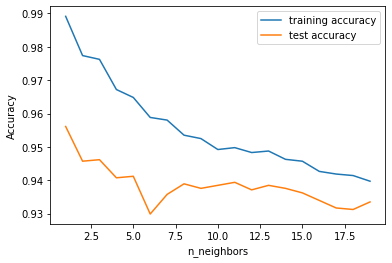

In [ ]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 20
depth = range(1,20)
for n in depth:
    knn = KNeighborsClassifier(n_neighbors=n)

    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(knn.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_neighbors")
plt.legend();

In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('K-Nearest Neighbors',acc_test_knn,f1_score_test_knn,
             recall_score_train_knn,precision_score_train_knn)

#5.3. Support Vector Machine : Classifier

In [ ]:
# Support Vector Classifier model 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'gamma': [0.1],'kernel': ['rbf','linear']}

svc = GridSearchCV(SVC(), param_grid)

# fitting the model for grid search
svc.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'gamma': [0.1], 'kernel': ['rbf', 'linear']})

In [ ]:
#predicting the target value from the model for the samples
y_train_svc = svc.predict(X_train)
y_test_svc = svc.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_svc = metrics.accuracy_score(y_train,y_train_svc)
acc_test_svc = metrics.accuracy_score(y_test,y_test_svc)
print("Support Vector Machine : Accuracy on training Data: {:.3f}".format(acc_train_svc))
print("Support Vector Machine : Accuracy on test Data: {:.3f}".format(acc_test_svc))
print()

f1_score_train_svc = metrics.f1_score(y_train,y_train_svc)
f1_score_test_svc = metrics.f1_score(y_test,y_test_svc)
print("Support Vector Machine : f1_score on training Data: {:.3f}".format(f1_score_train_svc))
print("Support Vector Machine : f1_score on test Data: {:.3f}".format(f1_score_test_svc))
print()

recall_score_train_svc = metrics.recall_score(y_train,y_train_svc)
recall_score_test_svc = metrics.recall_score(y_test,y_test_svc)
print("Support Vector Machine : Recall on training Data: {:.3f}".format(recall_score_train_svc))
print("Support Vector Machine : Recall on test Data: {:.3f}".format(recall_score_test_svc))
print()

precision_score_train_svc = metrics.precision_score(y_train,y_train_svc)
precision_score_test_svc = metrics.precision_score(y_test,y_test_svc)
print("Support Vector Machine : precision on training Data: {:.3f}".format(precision_score_train_svc))
print("Support Vector Machine : precision on test Data: {:.3f}".format(precision_score_test_svc))

Support Vector Machine : Accuracy on training Data: 0.969
Support Vector Machine : Accuracy on test Data: 0.964

Support Vector Machine : f1_score on training Data: 0.973
Support Vector Machine : f1_score on test Data: 0.968

Support Vector Machine : Recall on training Data: 0.980
Support Vector Machine : Recall on test Data: 0.980

Support Vector Machine : precision on training Data: 0.965
Support Vector Machine : precision on test Data: 0.957


In [ ]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_svc))

              precision    recall  f1-score   support

          -1       0.97      0.94      0.96       976
           1       0.96      0.98      0.97      1235

    accuracy                           0.96      2211
   macro avg       0.97      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Support Vector Machine',acc_test_svc,f1_score_test_svc,
             recall_score_train_svc,precision_score_train_svc)

#5.4. Naive Bayes : Classifier

In [ ]:
# Naive Bayes Classifier Model
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# instantiate the model
nb=  GaussianNB()

# fit the model 
nb.fit(X_train,y_train)

GaussianNB()

In [ ]:
#predicting the target value from the model for the samples
y_train_nb = nb.predict(X_train)
y_test_nb = nb.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_nb = metrics.accuracy_score(y_train,y_train_nb)
acc_test_nb = metrics.accuracy_score(y_test,y_test_nb)
print("Naive Bayes Classifier : Accuracy on training Data: {:.3f}".format(acc_train_nb))
print("Naive Bayes Classifier : Accuracy on test Data: {:.3f}".format(acc_test_nb))
print()

f1_score_train_nb = metrics.f1_score(y_train,y_train_nb)
f1_score_test_nb = metrics.f1_score(y_test,y_test_nb)
print("Naive Bayes Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_nb))
print("Naive Bayes Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_nb))
print()

recall_score_train_nb = metrics.recall_score(y_train,y_train_nb)
recall_score_test_nb = metrics.recall_score(y_test,y_test_nb)
print("Naive Bayes Classifier : Recall on training Data: {:.3f}".format(recall_score_train_nb))
print("Naive Bayes Classifier : Recall on test Data: {:.3f}".format(recall_score_test_nb))
print()

precision_score_train_nb = metrics.precision_score(y_train,y_train_nb)
precision_score_test_nb = metrics.precision_score(y_test,y_test_nb)
print("Naive Bayes Classifier : precision on training Data: {:.3f}".format(precision_score_train_nb))
print("Naive Bayes Classifier : precision on test Data: {:.3f}".format(precision_score_test_nb))

Naive Bayes Classifier : Accuracy on training Data: 0.605
Naive Bayes Classifier : Accuracy on test Data: 0.605

Naive Bayes Classifier : f1_score on training Data: 0.451
Naive Bayes Classifier : f1_score on test Data: 0.454

Naive Bayes Classifier : Recall on training Data: 0.292
Naive Bayes Classifier : Recall on test Data: 0.294

Naive Bayes Classifier : precision on training Data: 0.997
Naive Bayes Classifier : precision on test Data: 0.995


In [ ]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_svc))

              precision    recall  f1-score   support

          -1       0.97      0.94      0.96       976
           1       0.96      0.98      0.97      1235

    accuracy                           0.96      2211
   macro avg       0.97      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Naive Bayes Classifier',acc_test_nb,f1_score_test_nb,
             recall_score_train_nb,precision_score_train_nb)

#5.5. Decision Trees : Classifie

In [ ]:
# Decision Tree Classifier model 
from sklearn.tree import DecisionTreeClassifier

# instantiate the model 
tree = DecisionTreeClassifier(max_depth=30)

# fit the model 
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=30)

In [ ]:
#predicting the target value from the model for the samples

y_train_tree = tree.predict(X_train)
y_test_tree = tree.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_tree = metrics.accuracy_score(y_train,y_train_tree)
acc_test_tree = metrics.accuracy_score(y_test,y_test_tree)
print("Decision Tree : Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree : Accuracy on test Data: {:.3f}".format(acc_test_tree))
print()

f1_score_train_tree = metrics.f1_score(y_train,y_train_tree)
f1_score_test_tree = metrics.f1_score(y_test,y_test_tree)
print("Decision Tree : f1_score on training Data: {:.3f}".format(f1_score_train_tree))
print("Decision Tree : f1_score on test Data: {:.3f}".format(f1_score_test_tree))
print()

recall_score_train_tree = metrics.recall_score(y_train,y_train_tree)
recall_score_test_tree = metrics.recall_score(y_test,y_test_tree)
print("Decision Tree : Recall on training Data: {:.3f}".format(recall_score_train_tree))
print("Decision Tree : Recall on test Data: {:.3f}".format(recall_score_test_tree))
print()

precision_score_train_tree = metrics.precision_score(y_train,y_train_tree)
precision_score_test_tree = metrics.precision_score(y_test,y_test_tree)
print("Decision Tree : precision on training Data: {:.3f}".format(precision_score_train_tree))
print("Decision Tree : precision on test Data: {:.3f}".format(precision_score_test_tree))

Decision Tree : Accuracy on training Data: 0.991
Decision Tree : Accuracy on test Data: 0.959

Decision Tree : f1_score on training Data: 0.992
Decision Tree : f1_score on test Data: 0.963

Decision Tree : Recall on training Data: 0.991
Decision Tree : Recall on test Data: 0.960

Decision Tree : precision on training Data: 0.993
Decision Tree : precision on test Data: 0.967


In [ ]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_tree))

              precision    recall  f1-score   support

          -1       0.95      0.96      0.95       976
           1       0.97      0.96      0.96      1235

    accuracy                           0.96      2211
   macro avg       0.96      0.96      0.96      2211
weighted avg       0.96      0.96      0.96      2211



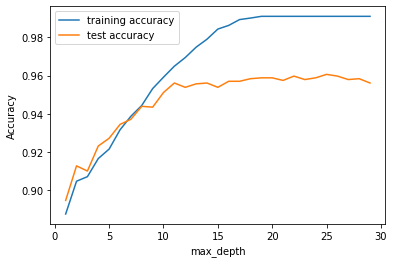

In [ ]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 30
depth = range(1,30)
for n in depth:
    tree_test = DecisionTreeClassifier(max_depth=n)

    tree_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(tree_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(tree_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for max_depth from 1 to 30
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend();

In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Decision Tree',acc_test_tree,f1_score_test_tree,
             recall_score_train_tree,precision_score_train_tree)

#5.6. Random Forest : Classifier

In [ ]:
# Random Forest Classifier Model
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
forest = RandomForestClassifier(n_estimators=10)

# fit the model 
forest.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [ ]:
#predicting the target value from the model for the samples
y_train_forest = forest.predict(X_train)
y_test_forest = forest.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_forest = metrics.accuracy_score(y_train,y_train_forest)
acc_test_forest = metrics.accuracy_score(y_test,y_test_forest)
print("Random Forest : Accuracy on training Data: {:.3f}".format(acc_train_forest))
print("Random Forest : Accuracy on test Data: {:.3f}".format(acc_test_forest))
print()

f1_score_train_forest = metrics.f1_score(y_train,y_train_forest)
f1_score_test_forest = metrics.f1_score(y_test,y_test_forest)
print("Random Forest : f1_score on training Data: {:.3f}".format(f1_score_train_forest))
print("Random Forest : f1_score on test Data: {:.3f}".format(f1_score_test_forest))
print()

recall_score_train_forest = metrics.recall_score(y_train,y_train_forest)
recall_score_test_forest = metrics.recall_score(y_test,y_test_forest)
print("Random Forest : Recall on training Data: {:.3f}".format(recall_score_train_forest))
print("Random Forest : Recall on test Data: {:.3f}".format(recall_score_test_forest))
print()

precision_score_train_forest = metrics.precision_score(y_train,y_train_forest)
precision_score_test_forest = metrics.precision_score(y_test,y_test_tree)
print("Random Forest : precision on training Data: {:.3f}".format(precision_score_train_forest))
print("Random Forest : precision on test Data: {:.3f}".format(precision_score_test_forest))

Random Forest : Accuracy on training Data: 0.990
Random Forest : Accuracy on test Data: 0.967

Random Forest : f1_score on training Data: 0.991
Random Forest : f1_score on test Data: 0.970

Random Forest : Recall on training Data: 0.994
Random Forest : Recall on test Data: 0.974

Random Forest : precision on training Data: 0.989
Random Forest : precision on test Data: 0.967


In [ ]:

#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_forest))

              precision    recall  f1-score   support

          -1       0.97      0.96      0.96       976
           1       0.97      0.97      0.97      1235

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



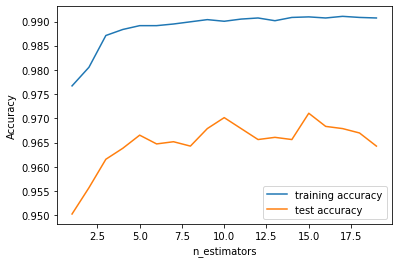

In [ ]:
training_accuracy = []
test_accuracy = []
# try max_depth from 1 to 20
depth = range(1,20)
for n in depth:
    forest_test =  RandomForestClassifier(n_estimators=n)

    forest_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 20
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("n_estimators")
plt.legend();

In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Random Forest',acc_test_forest,f1_score_test_forest,
             recall_score_train_forest,precision_score_train_forest)

#5.7.Gradient Boosting Classifier

In [ ]:

# Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier

# instantiate the model
gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)

# fit the model 
gbc.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [ ]:
#predicting the target value from the model for the samples
y_train_gbc = gbc.predict(X_train)
y_test_gbc = gbc.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_gbc = metrics.accuracy_score(y_train,y_train_gbc)
acc_test_gbc = metrics.accuracy_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Accuracy on training Data: {:.3f}".format(acc_train_gbc))
print("Gradient Boosting Classifier : Accuracy on test Data: {:.3f}".format(acc_test_gbc))
print()

f1_score_train_gbc = metrics.f1_score(y_train,y_train_gbc)
f1_score_test_gbc = metrics.f1_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_gbc))
print("Gradient Boosting Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_gbc))
print()

recall_score_train_gbc = metrics.recall_score(y_train,y_train_gbc)
recall_score_test_gbc =  metrics.recall_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : Recall on training Data: {:.3f}".format(recall_score_train_gbc))
print("Gradient Boosting Classifier : Recall on test Data: {:.3f}".format(recall_score_test_gbc))
print()

precision_score_train_gbc = metrics.precision_score(y_train,y_train_gbc)
precision_score_test_gbc = metrics.precision_score(y_test,y_test_gbc)
print("Gradient Boosting Classifier : precision on training Data: {:.3f}".format(precision_score_train_gbc))
print("Gradient Boosting Classifier : precision on test Data: {:.3f}".format(precision_score_test_gbc))

Gradient Boosting Classifier : Accuracy on training Data: 0.989
Gradient Boosting Classifier : Accuracy on test Data: 0.974

Gradient Boosting Classifier : f1_score on training Data: 0.990
Gradient Boosting Classifier : f1_score on test Data: 0.977

Gradient Boosting Classifier : Recall on training Data: 0.994
Gradient Boosting Classifier : Recall on test Data: 0.989

Gradient Boosting Classifier : precision on training Data: 0.986
Gradient Boosting Classifier : precision on test Data: 0.966


In [ ]:
#computing the classification report of the model

print(metrics.classification_report(y_test, y_test_gbc))

              precision    recall  f1-score   support

          -1       0.99      0.96      0.97       976
           1       0.97      0.99      0.98      1235

    accuracy                           0.97      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



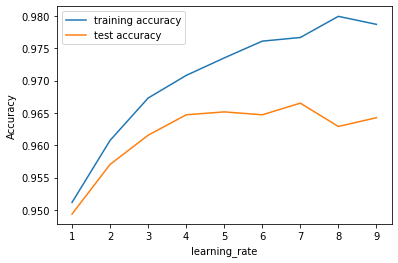

In [ ]:
training_accuracy = []
test_accuracy = []
# try learning_rate from 0.1 to 0.9
depth = range(1,10)
for n in depth:
    forest_test =  GradientBoostingClassifier(learning_rate = n*0.1)

    forest_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 50
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("learning_rate")
plt.legend();

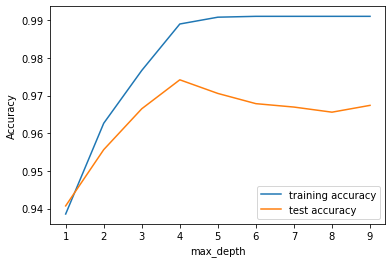

In [ ]:
training_accuracy = []
test_accuracy = []
# try learning_rate from 0.1 to 0.9
depth = range(1,10,1)
for n in depth:
    forest_test =  GradientBoostingClassifier(max_depth=n,learning_rate = 0.7)

    forest_test.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(forest_test.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(forest_test.score(X_test, y_test))
    

#plotting the training & testing accuracy for n_estimators from 1 to 50
plt.figure(figsize=None)
plt.plot(depth, training_accuracy, label="training accuracy")
plt.plot(depth, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")  
plt.xlabel("max_depth")
plt.legend();

In [ ]:

#storing the results. The below mentioned order of parameter passing is important.

storeResults('Gradient Boosting Classifier',acc_test_gbc,f1_score_test_gbc,
             recall_score_train_gbc,precision_score_train_gbc)


#5.8. XGBoost Classifier

In [ ]:
#  XGBoost Classifier Model
from xgboost import XGBClassifier

# instantiate the model
xgb = XGBClassifier()

# fit the model 
xgb.fit(X_train,y_train)

XGBClassifier()

In [ ]:
#predicting the target value from the model for the samples
y_train_xgb = xgb.predict(X_train)
y_test_xgb = xgb.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_xgb = metrics.accuracy_score(y_train,y_train_xgb)
acc_test_xgb = metrics.accuracy_score(y_test,y_test_xgb)
print("XGBoost Classifier : Accuracy on training Data: {:.3f}".format(acc_train_xgb))
print("XGBoost Classifier : Accuracy on test Data: {:.3f}".format(acc_test_xgb))
print()

f1_score_train_xgb = metrics.f1_score(y_train,y_train_xgb)
f1_score_test_xgb = metrics.f1_score(y_test,y_test_xgb)
print("XGBoost Classifier : f1_score on training Data: {:.3f}".format(f1_score_train_xgb))
print("XGBoost Classifier : f1_score on test Data: {:.3f}".format(f1_score_test_xgb))
print()

recall_score_train_xgb = metrics.recall_score(y_train,y_train_xgb)
recall_score_test_xgb = metrics.recall_score(y_test,y_test_xgb)
print("XGBoost Classifier : Recall on training Data: {:.3f}".format(recall_score_train_xgb))
print("XGBoost Classifier : Recall on test Data: {:.3f}".format(recall_score_train_xgb))
print()

precision_score_train_xgb = metrics.precision_score(y_train,y_train_xgb)
precision_score_test_xgb = metrics.precision_score(y_test,y_test_xgb)
print("XGBoost Classifier : precision on training Data: {:.3f}".format(precision_score_train_xgb))
print("XGBoost Classifier : precision on test Data: {:.3f}".format(precision_score_train_xgb))

XGBoost Classifier : Accuracy on training Data: 0.952
XGBoost Classifier : Accuracy on test Data: 0.952

XGBoost Classifier : f1_score on training Data: 0.957
XGBoost Classifier : f1_score on test Data: 0.958

XGBoost Classifier : Recall on training Data: 0.968
XGBoost Classifier : Recall on test Data: 0.968

XGBoost Classifier : precision on training Data: 0.947
XGBoost Classifier : precision on test Data: 0.947


In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('XGBoost Classifier',acc_test_xgb,f1_score_test_xgb,recall_score_train_xgb,precision_score_train_xgb)

#5.10. Multi-layer Perceptron classifier

In [ ]:
# Multi-layer Perceptron Classifier Model
from sklearn.neural_network import MLPClassifier

# instantiate the model
mlp = MLPClassifier()
#mlp = GridSearchCV(mlpc, parameter_space)

# fit the model 
mlp.fit(X_train,y_train)

MLPClassifier()

In [ ]:
#predicting the target value from the model for the samples
y_train_mlp = mlp.predict(X_train)
y_test_mlp = mlp.predict(X_test)

In [ ]:
#computing the accuracy, f1_score, Recall, precision of the model performance

acc_train_mlp  = metrics.accuracy_score(y_train,y_train_mlp)
acc_test_mlp = metrics.accuracy_score(y_test,y_test_mlp)
print("Multi-layer Perceptron : Accuracy on training Data: {:.3f}".format(acc_train_mlp))
print("Multi-layer Perceptron : Accuracy on test Data: {:.3f}".format(acc_test_mlp))
print()

f1_score_train_mlp = metrics.f1_score(y_train,y_train_mlp)
f1_score_test_mlp = metrics.f1_score(y_test,y_test_mlp)
print("Multi-layer Perceptron : f1_score on training Data: {:.3f}".format(f1_score_train_mlp))
print("Multi-layer Perceptron : f1_score on test Data: {:.3f}".format(f1_score_train_mlp))
print()

recall_score_train_mlp = metrics.recall_score(y_train,y_train_mlp)
recall_score_test_mlp = metrics.recall_score(y_test,y_test_mlp)
print("Multi-layer Perceptron : Recall on training Data: {:.3f}".format(recall_score_train_mlp))
print("Multi-layer Perceptron : Recall on test Data: {:.3f}".format(recall_score_test_mlp))
print()

precision_score_train_mlp = metrics.precision_score(y_train,y_train_mlp)
precision_score_test_mlp = metrics.precision_score(y_test,y_test_mlp)
print("Multi-layer Perceptron : precision on training Data: {:.3f}".format(precision_score_train_mlp))
print("Multi-layer Perceptron : precision on test Data: {:.3f}".format(precision_score_test_mlp))

Multi-layer Perceptron : Accuracy on training Data: 0.986
Multi-layer Perceptron : Accuracy on test Data: 0.972

Multi-layer Perceptron : f1_score on training Data: 0.987
Multi-layer Perceptron : f1_score on test Data: 0.987

Multi-layer Perceptron : Recall on training Data: 0.992
Multi-layer Perceptron : Recall on test Data: 0.985

Multi-layer Perceptron : precision on training Data: 0.983
Multi-layer Perceptron : precision on test Data: 0.964


In [ ]:
#storing the results. The below mentioned order of parameter passing is important.

storeResults('Multi-layer Perceptron',acc_test_mlp,f1_score_test_mlp,
             recall_score_train_mlp,precision_score_train_mlp)

#6. Comparision of Models

In [ ]:
#creating dataframe
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'f1_score' : f1_score,
                        'Recall'   : recall,
                        'Precision': precision,
                      })

In [ ]:
# dispalying total result
result

,ML Model,Accuracy,f1_score,Recall,Precision
0,Logistic Regression,0.934,0.941,0.943,0.927
1,K-Nearest Neighbors,0.956,0.961,0.991,0.989
2,Support Vector Machine,0.964,0.968,0.980,0.965
3,Naive Bayes Classifier,0.605,0.454,0.292,0.997
4,Decision Tree,0.959,0.963,0.991,0.993
5,Random Forest,0.967,0.970,0.994,0.989
6,Gradient Boosting Classifier,0.974,0.977,0.994,0.986
7,XGBoost Classifier,0.952,0.958,0.968,0.947
8,Multi-layer Perceptron,0.972,0.975,0.992,0.983


In [ ]:
#Sorting the datafram on accuracy
sorted_result=result.sort_values(by=['Accuracy', 'f1_score'],ascending=False).reset_index(drop=True)

In [ ]:
# dispalying total result
sorted_result

,ML Model,Accuracy,f1_score,Recall,Precision
0,Gradient Boosting Classifier,0.974,0.977,0.994,0.986
1,Multi-layer Perceptron,0.972,0.975,0.992,0.983
2,Random Forest,0.967,0.970,0.994,0.989
3,Support Vector Machine,0.964,0.968,0.980,0.965
4,Decision Tree,0.959,0.963,0.991,0.993
5,K-Nearest Neighbors,0.956,0.961,0.991,0.989
6,XGBoost Classifier,0.952,0.958,0.968,0.947
7,Logistic Regression,0.934,0.941,0.943,0.927
8,Naive Bayes Classifier,0.605,0.454,0.292,0.997


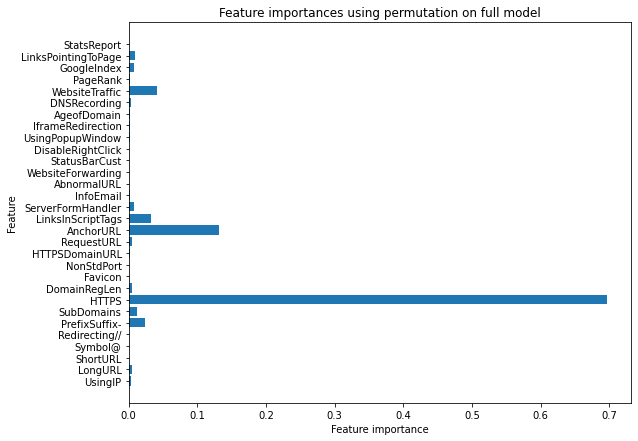

In [ ]:
#checking the feature improtance in the model
plt.figure(figsize=(9,7))
n_features = X_train.shape[1]
plt.barh(range(n_features), gbc.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X_train.columns)
plt.title("Feature importances using permutation on full model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')

# Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
data = pd.read_csv("phishing.csv")
#droping index column
data = data.drop(['Index'],axis = 1)
# Splitting the dataset into dependant and independant fetature

X = data.drop(["class"],axis =1)
y = data["class"]

# instantiate the model
gbc = GradientBoostingClassifier(max_depth=4,learning_rate=0.7)

# fit the model 
gbc.fit(X,y)


GradientBoostingClassifier(learning_rate=0.7, max_depth=4)

In [ ]:
 x = np.array(generate_data_set("https://www.linkedin.com")).reshape(1,30) 
 y_pred =gbc.predict(x)[0]
 #1 is safe       
 #-1 is unsafe
 y_pro_phishing = gbc.predict_proba(x)[0,0]
 y_pro_non_phishing = gbc.predict_proba(x)[0,1]
  # if(y_pred ==1 ):
 pred = "It is {0:.2f} % safe to go ".format(y_pro_phishing*100)
 print(y_pred)

1
